# Regression Analysis
In this notebook, we will perform predictive analytics using regression techniques. We will use machine learning to predict wages of labourer. Here is link to the data-set description:
https://vincentarelbundock.github.io/Rdatasets/doc/carData/SLID.html

In [1]:
# as data-set is in the form of CSV, so lets just load it as dataframe;
rdd = sc.textFile("/user/centos/SLID.csv")

In [2]:
df = spark.read.csv("/user/centos/SLID.csv")

In [3]:
df.show(n=5)

+----+-----+---------+---+----+--------+
| _c0|  _c1|      _c2|_c3| _c4|     _c5|
+----+-----+---------+---+----+--------+
|null|wages|education|age| sex|language|
|   1|10.56|       15| 40|Male| English|
|   2|   11|     13.2| 19|Male| English|
|   3|   NA|       16| 49|Male|   Other|
|   4|17.76|       14| 46|Male|   Other|
+----+-----+---------+---+----+--------+
only showing top 5 rows



In [4]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [5]:
# it appears that the data-set 6 columns.
# also that it has header in it. 
# the header isn't properly structured as the first column is null. 
# that column probably represents ID. Also, as per the description of the 
# data-set, its not in schema.
# create a dictionary with the column names and types in it.
from pyspark.sql.types import StringType,IntegerType,DoubleType
schema_dict = {"id":IntegerType(),
              "wages":DoubleType(),
              "education":DoubleType(),
              "age":IntegerType(),
              "sex":StringType(),
              "language":StringType()}

In [6]:

schema_dict

{'age': IntegerType,
 'education': DoubleType,
 'id': IntegerType,
 'language': StringType,
 'sex': StringType,
 'wages': DoubleType}

In [8]:
[x for x in schema_dict]

['language', 'age', 'sex', 'wages', 'education', 'id']

In [7]:
from pyspark.sql.types import StructType,StructField
def create_schema(given_schema_dict):
    fields_list = [StructField(x,given_schema_dict[x],True) for x in given_schema_dict]
    return StructType(fields_list)

In [8]:
df_schema = create_schema(schema_dict)

In [9]:
spark.read.csv("/user/centos/SLID.csv",schema=df_schema).show()

+--------+----+----+-----+---------+----+
|language| age| sex|wages|education|  id|
+--------+----+----+-----+---------+----+
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
|    null|null|null| null|     null|null|
+--------+----+----+-----+--------

In [10]:
# the dataframe is showing nulls. Why is this the case?
# if you use the dictionary created before, it will not load the data 
# correctly as it makes the data out of order. 
# Python's default dictionaries don't maintain order
# of elements. so a better approach is to use OrderedDict in Collections;

In [17]:
# i think convert rdd to dataframe?
all_string_fields = [StructField(x,StringType(),True) for x in ["id","wages","education","age","sex","language"]]

In [18]:
all_string_schema = StructType(all_string_fields)

In [12]:
#need to filter header:
header = rdd.first()

In [13]:
header

u'"","wages","education","age","sex","language"'

In [15]:
rdd.take(2)

[u'"","wages","education","age","sex","language"',
 u'"1",10.56,15,40,"Male","English"']

In [16]:
rdd_array = rdd.filter(lambda x: x!= header).map(lambda x: x.split(","))

In [19]:
slid_df_string = spark.createDataFrame(rdd_array,all_string_schema)

In [20]:
slid_df_string.printSchema()

root
 |-- id: string (nullable = true)
 |-- wages: string (nullable = true)
 |-- education: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- language: string (nullable = true)



In [21]:
def strip_quotes(given_value):
    return str(given_value[1:-1])

In [22]:
from pyspark.sql.functions import udf

In [23]:
strip_quotes_udf = udf(strip_quotes)

In [24]:
slid_df2=slid_df_string.select(strip_quotes_udf(slid_df_string.id).alias("id"),"wages","education","age",strip_quotes_udf(slid_df_string.sex).alias("sex"),strip_quotes_udf(slid_df_string.language).alias("language"))

In [25]:
slid_df2.show(3)

+---+-----+---------+---+----+--------+
| id|wages|education|age| sex|language|
+---+-----+---------+---+----+--------+
|  1|10.56|       15| 40|Male| English|
|  2|   11|     13.2| 19|Male| English|
|  3|   NA|       16| 49|Male|   Other|
+---+-----+---------+---+----+--------+
only showing top 3 rows



In [26]:
df=slid_df2.select(slid_df2.id.cast("Integer"),slid_df2.wages.cast("Integer"),slid_df2.education.cast("Integer"),slid_df2.age.cast("Integer"),"sex","language")

In [27]:
df.persist().show()

+---+-----+---------+---+------+--------+
| id|wages|education|age|   sex|language|
+---+-----+---------+---+------+--------+
|  1|   10|       15| 40|  Male| English|
|  2|   11|       13| 19|  Male| English|
|  3| null|       16| 49|  Male|   Other|
|  4|   17|       14| 46|  Male|   Other|
|  5| null|        8| 71|  Male| English|
|  6|   14|       16| 50|Female| English|
|  7| null|       12| 70|Female| English|
|  8| null|       14| 42|Female| English|
|  9|    8|       15| 31|  Male| English|
| 10| null|       10| 56|Female| English|
| 11| null|       12| 71|Female| English|
| 12|   16|       13| 30|Female| English|
| 13| null|        2| 56|  Male| English|
| 14|    6|       12| 61|Female| English|
| 15| null|       12| 25|Female| English|
| 16| null|       11| 36|Female|  French|
| 17| null|       11| 54|Female| English|
| 18| null|       10| 62|Female| English|
| 19| null|       10| 70|Female| English|
| 20|   14|       14| 46|Female|   Other|
+---+-----+---------+---+------+--

In [28]:
num_rows = df.count()

In [29]:
import pyspark.sql.functions as funct

In [30]:
missing_val_dict=dict()
for col in df.columns:
    num_missing=df.agg(funct.count(col)).rdd.flatMap(lambda row:row).collect()
    missing_val_dict[col]=num_rows-num_missing[0]
    

In [31]:
missing_val_dict
# so there are around 3278 missing values in the wages column!

{'age': 0, 'education': 249, 'id': 0, 'language': 0, 'sex': 0, 'wages': 3278}

In [159]:
# you probably deleted some cells here. try getting them from the rough
# notebook;
# skipping this and going to the end of this notebook. as the subsequent
# sections talk about visualization;
df.show()

+---+-----+---------+---+------+--------+
| id|wages|education|age|   sex|language|
+---+-----+---------+---+------+--------+
|  1|   10|       15| 40|  Male| English|
|  2|   11|       13| 19|  Male| English|
|  3| null|       16| 49|  Male|   Other|
|  4|   17|       14| 46|  Male|   Other|
|  5| null|        8| 71|  Male| English|
|  6|   14|       16| 50|Female| English|
|  7| null|       12| 70|Female| English|
|  8| null|       14| 42|Female| English|
|  9|    8|       15| 31|  Male| English|
| 10| null|       10| 56|Female| English|
| 11| null|       12| 71|Female| English|
| 12|   16|       13| 30|Female| English|
| 13| null|        2| 56|  Male| English|
| 14|    6|       12| 61|Female| English|
| 15| null|       12| 25|Female| English|
| 16| null|       11| 36|Female|  French|
| 17| null|       11| 54|Female| English|
| 18| null|       10| 62|Female| English|
| 19| null|       10| 70|Female| English|
| 20|   14|       14| 46|Female|   Other|
+---+-----+---------+---+------+--

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline



In [33]:


wages_education_sample = df.select(["wages","language"]).sample(False,0.2,40).rdd.flatMap(lambda row:row).collect()

we_sample=df.select(["wages","education"]).sample(False,0.2,100)\
.rdd.map(lambda row: (row[0],row[1])).collect()

#we_sample
w_sample=[w[0] for w in we_sample]

e_sample=[w[1] for w in we_sample]

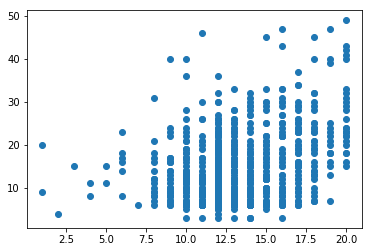

In [34]:
plt.scatter(e_sample,w_sample)

In [35]:
#now try doing for wages and age:
wa_sample=df.select(["wages","age"]).sample(True,0.2,100).rdd\
.map(lambda row:(row[0],row[1])).collect()

In [36]:
w_sample=[w[0] for w in wa_sample]
a_sample=[a[1] for a in wa_sample]

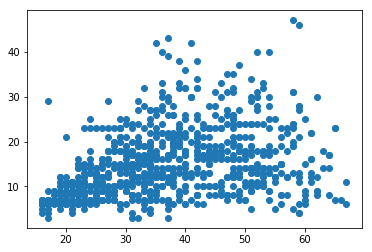

In [37]:
plt.scatter(a_sample,w_sample)

In [38]:
#for boxplot;
w_eng_sample=df.filter("language == 'English'").select(["wages"]).sample(False,0.2,100)\
.rdd.flatMap(lambda row:row).collect()

In [39]:
w_french_sample = df.filter("language == 'French'")\
.select(["wages"]).rdd.flatMap(lambda row:row).collect()

In [40]:
import numpy as np
np_w_eng_sample=np.array(w_eng_sample)

In [41]:
#plt.box(np_w_eng_sample)#? not showing; 

In [42]:
#clean the lists?
w_eng_sample_clean=[x for x in w_eng_sample if x != None]
w_french_sample_clean=[x for x in w_french_sample if x!= None]

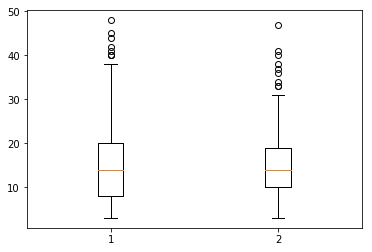

In [43]:
plt.boxplot([w_eng_sample_clean,w_french_sample_clean])
plt.show()

In [46]:
# just simple regression first. but need to impute
# the wages variable first;
# so education and wages are the two columns which have missing values. 
# will impute them with a mean value;
# for that, creating a dictionary that will consist of column_name:column_mean
all_col_means= df.agg(*[funct.mean(c).alias(c) for c in df.columns \
                             if c in ["education","wages"]]).\
toPandas().to_dict("record")[0]


In [47]:
all_col_means

{'education': 12.389910813823857, 'wages': 15.126356402218471}

In [48]:
df.show()

+---+-----+---------+---+------+--------+
| id|wages|education|age|   sex|language|
+---+-----+---------+---+------+--------+
|  1|   10|       15| 40|  Male| English|
|  2|   11|       13| 19|  Male| English|
|  3| null|       16| 49|  Male|   Other|
|  4|   17|       14| 46|  Male|   Other|
|  5| null|        8| 71|  Male| English|
|  6|   14|       16| 50|Female| English|
|  7| null|       12| 70|Female| English|
|  8| null|       14| 42|Female| English|
|  9|    8|       15| 31|  Male| English|
| 10| null|       10| 56|Female| English|
| 11| null|       12| 71|Female| English|
| 12|   16|       13| 30|Female| English|
| 13| null|        2| 56|  Male| English|
| 14|    6|       12| 61|Female| English|
| 15| null|       12| 25|Female| English|
| 16| null|       11| 36|Female|  French|
| 17| null|       11| 54|Female| English|
| 18| null|       10| 62|Female| English|
| 19| null|       10| 70|Female| English|
| 20|   14|       14| 46|Female|   Other|
+---+-----+---------+---+------+--

In [49]:
# now using the dictionary above to impute:

df2 = df.na.fill(all_col_means)

In [50]:
df2.show()

+---+-----+---------+---+------+--------+
| id|wages|education|age|   sex|language|
+---+-----+---------+---+------+--------+
|  1|   10|       15| 40|  Male| English|
|  2|   11|       13| 19|  Male| English|
|  3|   15|       16| 49|  Male|   Other|
|  4|   17|       14| 46|  Male|   Other|
|  5|   15|        8| 71|  Male| English|
|  6|   14|       16| 50|Female| English|
|  7|   15|       12| 70|Female| English|
|  8|   15|       14| 42|Female| English|
|  9|    8|       15| 31|  Male| English|
| 10|   15|       10| 56|Female| English|
| 11|   15|       12| 71|Female| English|
| 12|   16|       13| 30|Female| English|
| 13|   15|        2| 56|  Male| English|
| 14|    6|       12| 61|Female| English|
| 15|   15|       12| 25|Female| English|
| 16|   15|       11| 36|Female|  French|
| 17|   15|       11| 54|Female| English|
| 18|   15|       10| 62|Female| English|
| 19|   15|       10| 70|Female| English|
| 20|   14|       14| 46|Female|   Other|
+---+-----+---------+---+------+--

In [51]:
# string encode the sex and language columns:
from pyspark.ml.feature import StringIndexer
string_cols = ["sex","language"]
for col in string_cols:
    string_indexer=StringIndexer(inputCol=col,outputCol=col+"_index")
    model=string_indexer.fit(df2)
    df2=model.transform(df2)

In [52]:
df2.show()

+---+-----+---------+---+------+--------+---------+--------------+
| id|wages|education|age|   sex|language|sex_index|language_index|
+---+-----+---------+---+------+--------+---------+--------------+
|  1|   10|       15| 40|  Male| English|      1.0|           0.0|
|  2|   11|       13| 19|  Male| English|      1.0|           0.0|
|  3|   15|       16| 49|  Male|   Other|      1.0|           1.0|
|  4|   17|       14| 46|  Male|   Other|      1.0|           1.0|
|  5|   15|        8| 71|  Male| English|      1.0|           0.0|
|  6|   14|       16| 50|Female| English|      0.0|           0.0|
|  7|   15|       12| 70|Female| English|      0.0|           0.0|
|  8|   15|       14| 42|Female| English|      0.0|           0.0|
|  9|    8|       15| 31|  Male| English|      1.0|           0.0|
| 10|   15|       10| 56|Female| English|      0.0|           0.0|
| 11|   15|       12| 71|Female| English|      0.0|           0.0|
| 12|   16|       13| 30|Female| English|      0.0|           

In [100]:
df2.groupBy("language_index").count().show()

+--------------+-----+
|language_index|count|
+--------------+-----+
|           0.0| 5716|
|           1.0| 1091|
|           3.0|  121|
|           2.0|  497|
+--------------+-----+



In [118]:
df2.count()

7425

In [121]:
df2.printSchema()

root
 |-- id: integer (nullable = true)
 |-- wages: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- language: string (nullable = true)
 |-- sex_index: double (nullable = false)
 |-- language_index: double (nullable = false)



In [132]:
# create linear regression model:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [133]:
# creating feature vector of the features:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [134]:
df2.show()

+---+-----+---------+---+------+--------+---------+--------------+
| id|wages|education|age|   sex|language|sex_index|language_index|
+---+-----+---------+---+------+--------+---------+--------------+
|  1|   10|       15| 40|  Male| English|      1.0|           0.0|
|  2|   11|       13| 19|  Male| English|      1.0|           0.0|
|  3|   15|       16| 49|  Male|   Other|      1.0|           1.0|
|  4|   17|       14| 46|  Male|   Other|      1.0|           1.0|
|  5|   15|        8| 71|  Male| English|      1.0|           0.0|
|  6|   14|       16| 50|Female| English|      0.0|           0.0|
|  7|   15|       12| 70|Female| English|      0.0|           0.0|
|  8|   15|       14| 42|Female| English|      0.0|           0.0|
|  9|    8|       15| 31|  Male| English|      1.0|           0.0|
| 10|   15|       10| 56|Female| English|      0.0|           0.0|
| 11|   15|       12| 71|Female| English|      0.0|           0.0|
| 12|   16|       13| 30|Female| English|      0.0|           

In [135]:
v_assembler = VectorAssembler(inputCols=["age","education","sex_index"],
                            outputCol="features")

In [136]:
df3 = v_assembler.transform(df2)

In [ ]:
df

In [137]:
df4 = df3.withColumn("label",df3.wages).select("features","label")

In [138]:
df4.show()

+---------------+-----+
|       features|label|
+---------------+-----+
|[40.0,15.0,1.0]|   10|
|[19.0,13.0,1.0]|   11|
|[49.0,16.0,1.0]|   15|
|[46.0,14.0,1.0]|   17|
| [71.0,8.0,1.0]|   15|
|[50.0,16.0,0.0]|   14|
|[70.0,12.0,0.0]|   15|
|[42.0,14.0,0.0]|   15|
|[31.0,15.0,1.0]|    8|
|[56.0,10.0,0.0]|   15|
|[71.0,12.0,0.0]|   15|
|[30.0,13.0,0.0]|   16|
| [56.0,2.0,1.0]|   15|
|[61.0,12.0,0.0]|    6|
|[25.0,12.0,0.0]|   15|
|[36.0,11.0,0.0]|   15|
|[54.0,11.0,0.0]|   15|
|[62.0,10.0,0.0]|   15|
|[70.0,10.0,0.0]|   15|
|[46.0,14.0,0.0]|   14|
+---------------+-----+
only showing top 20 rows



In [139]:
train_df,test_df = df4.randomSplit([0.8,0.2],seed=100)

In [141]:
lrModel= lr.fit(train_df)

In [142]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0674089269293,0.403181288928,1.32427881264]
Intercept: 6.47309597496
numIterations: 7
objectiveHistory: [0.5000000000000004, 0.49096439841153194, 0.4603347002723688, 0.46027866451480165, 0.4602445062344532, 0.4602444553713322, 0.46024445215299614]
+-------------------+
|          residuals|
+-------------------+
| -4.358001383685794|
| 3.8197295938196376|
| -6.504549218825034|
|0.49545078117496644|
| 2.4954507811749664|
| -6.583451695108158|
| -5.583451695108158|
| -5.583451695108158|
|  3.416548304891842|
|  3.416548304891842|
|  3.416548304891842|
|  3.416548304891842|
|  3.416548304891842|
|  3.416548304891842|
| -9.907730507752829|
| -6.907730507752829|
| -6.907730507752829|
| -6.907730507752829|
|  2.092269492247171|
|  2.092269492247171|
+-------------------+
only showing top 20 rows

RMSE: 5.486120
r2: 0.124982


In [143]:
#use standard scaler:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

In [144]:
df4.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [145]:
scaler_model = scaler.fit(df4)

In [146]:
df5 = scaler_model.transform(df4)

In [147]:
train_df5,test_df5 = df5.randomSplit([0.8,0.2],seed=99)

In [148]:
lrModel= lr.fit(train_df5)

In [149]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0671214847268,0.394844904481,1.38950407911]
Intercept: 6.50921359508
numIterations: 7
objectiveHistory: [0.5000000000000004, 0.49075088765700525, 0.45963879726068324, 0.45959831066735896, 0.4595785117623695, 0.4595784784729489, 0.45957847637291255]
+-------------------+
|          residuals|
+-------------------+
| -4.372847159669117|
|  3.863238508963075|
|  -6.52626557014773|
|0.47373442985226966|
| 2.4737344298522697|
|  -6.53160639551804|
|  -5.53160639551804|
|  -5.53160639551804|
|  -5.53160639551804|
| 3.4683936044819603|
| 3.4683936044819603|
| 3.4683936044819603|
| 3.4683936044819603|
| 3.4683936044819603|
| 3.4683936044819603|
| -7.921110474628845|
| -6.921110474628845|
| -6.921110474628845|
| -3.921110474628845|
|  2.078889525371155|
+-------------------+
only showing top 20 rows

RMSE: 5.473964
r2: 0.126446
